In [1]:
# import libraries
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")

In [2]:
# read in data
spotify_data = pd.read_csv('SpotifyFeatures.csv')
spotify_data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [3]:
# one hot encoding so faetures can be used in vector space
spotify_features_df = spotify_data
genre_OHE = pd.get_dummies(spotify_features_df.genre)
key_OHE = pd.get_dummies(spotify_features_df.key)

In [4]:
# standardize scaling the features
scaled_features = MinMaxScaler().fit_transform([
  spotify_features_df['acousticness'].values,
  spotify_features_df['danceability'].values,
  spotify_features_df['duration_ms'].values,
  spotify_features_df['energy'].values,
  spotify_features_df['instrumentalness'].values,
  spotify_features_df['liveness'].values,
  spotify_features_df['loudness'].values,
  spotify_features_df['speechiness'].values,
  spotify_features_df['tempo'].values,
  spotify_features_df['valence'].values,
  ])

In [5]:
#Storing the transformed column vectors into our dataframe
spotify_features_df[['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']] = scaled_features.T

In [6]:
#discarding the categorical and unnecessary features 
spotify_features_df = spotify_features_df.drop('genre',axis = 1)
spotify_features_df = spotify_features_df.drop('artist_name', axis = 1)
spotify_features_df = spotify_features_df.drop('track_name', axis = 1)
spotify_features_df = spotify_features_df.drop('popularity',axis = 1)
spotify_features_df = spotify_features_df.drop('key', axis = 1)
spotify_features_df = spotify_features_df.drop('mode', axis = 1)
spotify_features_df = spotify_features_df.drop('time_signature', axis = 1)

In [7]:
#Appending the OHE columns of the categorical features
spotify_features_df = spotify_features_df.join(genre_OHE)
spotify_features_df = spotify_features_df.join(key_OHE)

In [8]:
spotify_features_df.head()

,track_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,B,C,C#,D,D#,E,F,F#,G,G#
0,0BRjO6ga9RKCKjfDqeFgWV,0.000025,0.000022,1.0,0.000028,0.000018,0.000022,0.0,0.000019,0.001699,...,0,0,1,0,0,0,0,0,0,0
1,0BjC1NfoEOOusryehmNudP,0.000042,0.000045,1.0,0.000046,0.000040,0.000042,0.0,0.000041,0.001307,...,0,0,0,0,0,0,0,1,0,0
2,0CoSDzoNIKCRs124s9uTVy,0.000087,0.000085,1.0,0.000082,0.000082,0.000082,0.0,0.000082,0.000666,...,0,1,0,0,0,0,0,0,0,0
3,0Gc6TVm52BwZD07Ki6tIvf,0.000084,0.000081,1.0,0.000082,0.000080,0.000081,0.0,0.000080,0.001207,...,0,0,1,0,0,0,0,0,0,0
4,0IuslXpMROHdEPvSl1fTQK,0.000267,0.000260,1.0,0.000259,0.000257,0.000258,0.0,0.000256,0.001957,...,0,0,0,0,0,0,1,0,0,0


In [9]:
# connect to spotify web api
client_id = '042d5638d13044be81a5e03b38df06a1' 
client_secret= 'f25316c8f2ea4fc79eba56cb57d25bf8'

In [10]:
#Fetching the playlist
scope = 'user-library-read'
token = util.prompt_for_user_token(
    scope, 
    client_id= client_id, 
    client_secret=client_secret, 
    redirect_uri='http://localhost:190'
  )
sp = spotipy.Spotify(auth=token)
playlist_dic = {}
playlist_cover_art = {}

for i in sp.current_user_playlists()['items']:
    playlist_dic[i['name']] = i['uri'].split(':')[2]
    playlist_cover_art[i['uri'].split(':')[2]] = i['images'][0]['url']

print(playlist_dic)

{'Hudsa Education': '3wGQaRMLOk6QYCmWgmUfq6', 'International': '5K7h8tEgjH4F0AutI8042a', 'Happy': '6WAQDbVI2bHuy7LGZlARoC', '1': '2TRctpNpic1wi4L3AKgx3W'}


In [11]:
#creating the playlist dataframe with extended features using Spotify data
def generate_playlist_df(playlist_name, playlist_dic, spotify_data):
    
    playlist = pd.DataFrame()

    for i, j in enumerate(sp.playlist(playlist_dic[playlist_name])['tracks']['items']):
        playlist.loc[i, 'artist'] = j['track']['artists'][0]['name']
        playlist.loc[i, 'track_name'] = j['track']['name']
        playlist.loc[i, 'track_id'] = j['track']['id']
        playlist.loc[i, 'url'] = j['track']['album']['images'][1]['url']
        playlist.loc[i, 'date_added'] = j['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['track_id'].isin(spotify_data['track_id'].values)].sort_values('date_added',ascending = False)

    return playlist
playlist_df = generate_playlist_df('Happy', playlist_dic, spotify_data) 

In [12]:
playlist_df.head()

,artist,track_name,track_id,url,date_added
27,Jonas Blue,Mama,47OVNnZJzIkrsEiZ4n187p,https://i.scdn.co/image/ab67616d00001e0221367d8a475851a923438320,2018-10-21 10:04:52+00:00
26,Liam Payne,Strip That Down,4Ro98RCK90oHqqSZUnTFq5,https://i.scdn.co/image/ab67616d00001e02bb19faf82c27f392e29c7300,2018-10-21 10:04:48+00:00
25,Fifth Harmony,Work from Home (feat. Ty Dolla $ign),4tCtwWceOPWzenK2HAIJSb,https://i.scdn.co/image/ab67616d00001e02d03fa6f4e758282b7920b5c8,2018-10-21 10:03:21+00:00
24,Thirty Seconds To Mars,Walk On Water,6FT9FZccFD6nE8dMNslz2n,https://i.scdn.co/image/ab67616d00001e02e98fa92fdb4f1a176ddc138f,2018-10-21 10:03:09+00:00
20,Steve Aoki,Just Hold On,3EmmCZoqpWOTY1g2GBwJoR,https://i.scdn.co/image/ab67616d00001e0222e2ce2de8bad6d67ee69b48,2018-10-21 10:00:48+00:00


In [13]:
# visualizing the data
from skimage import io
import matplotlib.pyplot as plt

def visualize_cover_art(playlist_df):
    temp = playlist_df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))) , facecolor='#8cfc03')
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(len(temp) / columns + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        s='' 
        plt.xlabel(s.join(playlist_df['track_name'].values[i].split(' ')[:4]), fontsize = 10, fontweight='bold')
        plt.tight_layout(h_pad=0.8, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

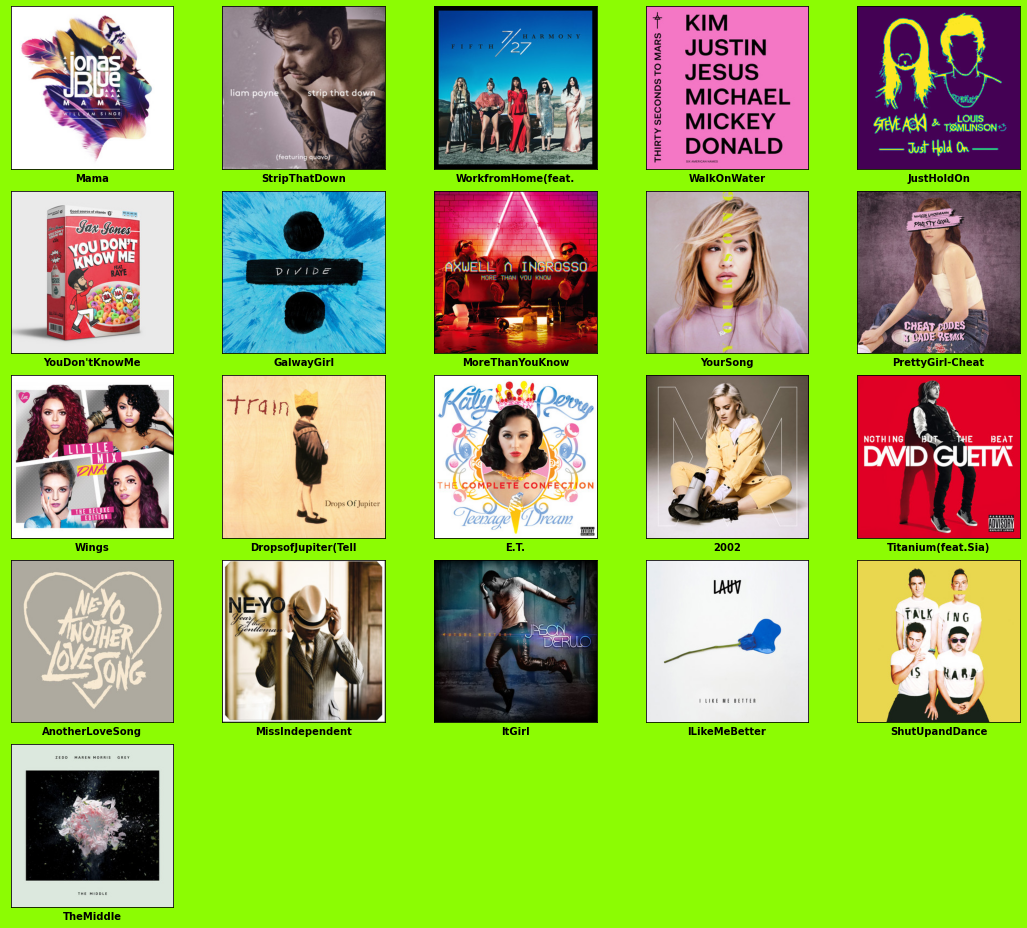

In [14]:
visualize_cover_art(playlist_df)

In [15]:
# returns our playlist as a single vector and all the songs not present in our playlist in a dataframe
def generate_playlist_vector(spotify_features, playlist_df, weight_factor):
    
    spotify_features_playlist = spotify_features[spotify_features['track_id'].isin(playlist_df['track_id'].values)]
    spotify_features_playlist = spotify_features_playlist.merge(playlist_df[['track_id','date_added']], on = 'track_id', how = 'inner')
    
    spotify_features_nonplaylist = spotify_features[~spotify_features['track_id'].isin(playlist_df['track_id'].values)]
    
    playlist_feature_set = spotify_features_playlist.sort_values('date_added',ascending=False)
    
    
    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'days_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days)
        
    
    playlist_feature_set['weight'] = playlist_feature_set['days_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-3].mul(playlist_feature_set_weighted.weight.astype(int),0))   
    
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-3]
    

    
    return playlist_feature_set_weighted_final.sum(axis = 0), spotify_features_nonplaylist


In [16]:
playlist_vector, nonplaylist_df = generate_playlist_vector(spotify_features_df, playlist_df, 1.2)
print(playlist_vector.shape)
print(nonplaylist_df.head())

NumExpr defaulting to 8 threads.


(50,)
                 track_id  acousticness  danceability  duration_ms    energy  \
0  0BRjO6ga9RKCKjfDqeFgWV      0.000025      0.000022          1.0  0.000028   
1  0BjC1NfoEOOusryehmNudP      0.000042      0.000045          1.0  0.000046   
2  0CoSDzoNIKCRs124s9uTVy      0.000087      0.000085          1.0  0.000082   
3  0Gc6TVm52BwZD07Ki6tIvf      0.000084      0.000081          1.0  0.000082   
4  0IuslXpMROHdEPvSl1fTQK      0.000267      0.000260          1.0  0.000259   

   instrumentalness  liveness  loudness  speechiness     tempo  ...  B  C  C#  \
0          0.000018  0.000022       0.0     0.000019  0.001699  ...  0  0   1   
1          0.000040  0.000042       0.0     0.000041  0.001307  ...  0  0   0   
2          0.000082  0.000082       0.0     0.000082  0.000666  ...  0  1   0   
3          0.000080  0.000081       0.0     0.000080  0.001207  ...  0  0   1   
4          0.000257  0.000258       0.0     0.000256  0.001957  ...  0  0   0   

   D  D#  E  F  F#  G  G# 

In [17]:
# generate the top recommendations of songs as our recommended playlist
def generate_recommendation(spotify_data, playlist_vector, nonplaylist_df):

    non_playlist = spotify_data[spotify_data['track_id'].isin(nonplaylist_df['track_id'].values)]
    non_playlist['sim'] = cosine_similarity(nonplaylist_df.drop(['track_id'], axis = 1).values, playlist_vector.drop(labels = 'track_id').values.reshape(1, -1))[:,0]
    non_playlist_top15 = non_playlist.sort_values('sim',ascending = False).head(15)
    non_playlist_top15['url'] = non_playlist_top15['track_id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return  non_playlist_top15

In [18]:
top15 = generate_recommendation(spotify_data, playlist_vector, nonplaylist_df)  
top15.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,sim,url
109841,Pop,Lil Baby,Global,7cW1wHpSLYgKWzoWlOCPFJ,71,0.000039,0.000042,1.0,0.000042,0.000038,C#,0.000039,0.0,Major,0.000041,0.001003,4/4,0.000040,0.826471,https://i.scdn.co/image/ab67616d00001e027cb0c4f7761f6dd66aaca065
149383,Pop,21 Savage,Disrespectful,3oxCefEI6Tc6Z6t20J4IvH,64,0.000047,0.000050,1.0,0.000047,0.000045,C#,0.000045,0.0,Major,0.000047,0.001030,4/4,0.000045,0.826471,https://i.scdn.co/image/ab67616d00001e020db43130a9aaa7bae56967ed
111829,Pop,Alessia Cara,Growing Pains,003eoIwxETJujVWmNFMoZy,66,0.000033,0.000034,1.0,0.000036,0.000032,C#,0.000034,0.0,Minor,0.000036,0.001019,4/4,0.000035,0.826471,https://i.scdn.co/image/ab67616d00001e0228f6d554b82dd6910c1df0b1
108970,Pop,21 Savage,asmr,2QgfDF0fQ4sskDthP8MG5w,75,0.000045,0.000050,1.0,0.000048,0.000045,C#,0.000046,0.0,Major,0.000048,0.001035,4/4,0.000046,0.826471,https://i.scdn.co/image/ab67616d00001e02280689ecc5e4b2038bb5e4bd
110769,Pop,Mac Miller,Donald Trump,2e0PQjgRNMDKeaMH49tHnC,65,0.000030,0.000034,1.0,0.000036,0.000030,C#,0.000032,0.0,Minor,0.000031,0.001021,4/4,0.000035,0.826471,https://i.scdn.co/image/ab67616d00001e0212a65cdcb2f5c6d08005a4c8


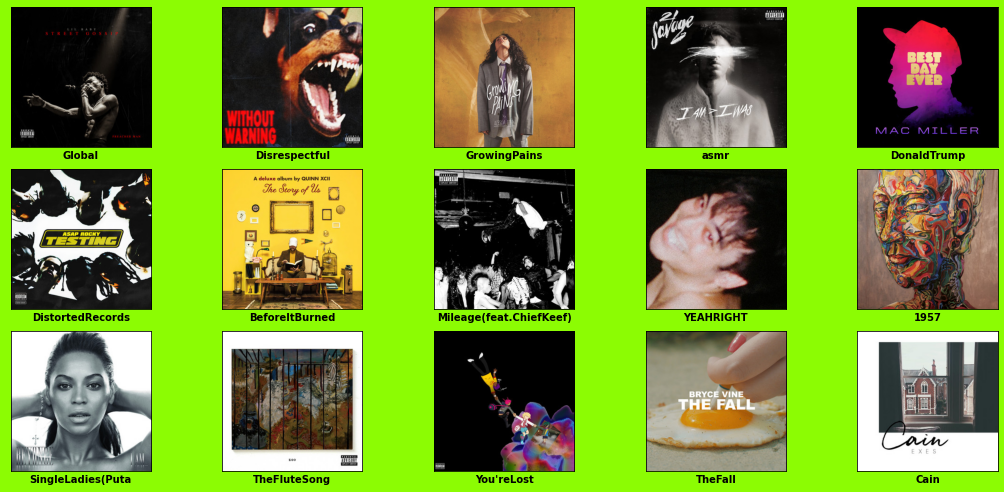

In [20]:
#Visulaizing the cover-art of the recommended playlist
visualize_cover_art(top15)